In [1]:
import ot
import numpy as np
import torch
from ot_mmd.mmdot import solve_apgd
from ot_mmd.utils import get_cost_G, get_dist
import matplotlib.pyplot as plt


dtype = torch.float
device = torch.device("cuda")

def tensor_to(tnsr):
    return tnsr.to(device, dtype)

def to_list(tnsr):
    return [i.item() for i in tnsr]

def get_samples(n, d=10):
    torch.manual_seed(0)
    x = tensor_to(torch.rand(2*n, d))
    mean_x = x.mean(axis=0)
    std_x = x.std(axis=0)
    x = (x-mean_x)/std_x
    x1 = x[:n]
    x2 = x[n:]
    return x1, x2

max_iter = 1000
lda = 1
khp = 1
ktype = "rbf"
y_obj = "Objective"
n_samples = [500, 1000, 2500, 5000, 10000]

obj = []
for n in n_samples:
    print(n)
    mu = tensor_to(torch.Tensor(n*[1.0/n]))
    x1, x2 = get_samples(n)
    C, G = get_cost_G(x1, x2, khp, ktype, p=2)
    v = {1: mu, 2: mu}
    _, obj_final = solve_apgd(C, G, v, max_iter, lda)

    obj.append(obj_final[-1].item())
    del C, G, mu, x1, x2, v

500
1000
2500
5000
10000


In [3]:
def get_obj_kl(reg=0.01, reg_m=1):
    obj = []
    for n in n_samples:
        print(n)
        mu = tensor_to(torch.Tensor(n*[1.0/n]))
        x1, x2 = get_samples(n)
        C = get_dist(x1, x2, p=2)
        C = C/C.max()
        try:
            obj.append((ot.unbalanced.sinkhorn_unbalanced2(mu, mu, C, reg=reg, reg_m=reg_m, method='sinkhorn'))) #_stabilized'))
        except Exception as e:
            print(e)
            break
        del C
    return obj
obj_kl = get_obj_kl()
obj_kl_arr = [i.item() for i in obj_kl]
obj_kl_arr

500
1000
2500
5000
10000


[0.07702602446079254,
 0.06532301753759384,
 0.05481790751218796,
 0.05012136325240135,
 0.04762697592377663]

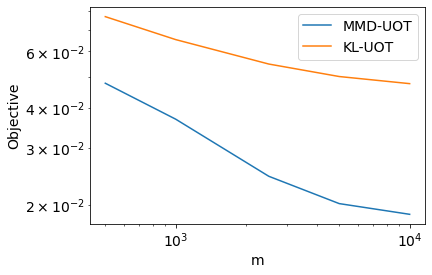

In [4]:
plt.rcParams.update({'font.size': 14})

plt.clf()
plt.loglog(n_samples, obj, label="MMD-UOT")
plt.loglog(n_samples, obj_kl_arr, label="KL-UOT")
plt.xlabel('m')
plt.ylabel('Objective')
plt.legend(loc='upper right')
plt.savefig('sc-kl-mmduot.jpg', bbox_inches = 'tight', pad_inches = 0.25)
plt.show()